# Ensemble
In this notebook, we will build ensemble models using the best models developed so far. Our specific objectives include creating a model with the highest accuracy on the test set and another model optimized for the best precision on non-leukemia images.

# Import and Costants

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from keras.models import Model
import pdb
import matplotlib.cm as cm
import tensorflow_addons as tfa
from vit_keras import vit
import random as rn

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Connection to Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Utils.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In the function for model evaluation, we provide both the accuracy on the dataset and the precision specifically for the "hem" class. This is important as it helps us assess the model's ability to avoid misclassifying cells with cancer as "hem."

In [ ]:
def evaluate_model(true_labels, predicted_labels):

  # 0 --> all and 1 --> hem
  true_labels = np.where(true_labels == 0, "all", "hem")
  predicted_labels = np.where(predicted_labels == 0, "all", "hem")

  print("Accuracy on the set: " + str(metrics.accuracy_score(true_labels, predicted_labels)))
  print(metrics.classification_report(true_labels, predicted_labels, target_names=["all", "hem"], digits=4))
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', ax=ax, display_labels=["all", "hem"])

def get_accuracy_and_nocancer_precision(true_labels, predicted_labels):

  # 0 --> all and 1 --> hem
  true_labels = np.where(true_labels == 0, "all", "hem")
  predicted_labels = np.where(predicted_labels == 0, "all", "hem")

  return metrics.accuracy_score(true_labels, predicted_labels), metrics.precision_score(true_labels, predicted_labels, average='macro',labels=["hem"])

We will also handle the downloading and extraction of the dataset from the Google Drive folder.

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-split.zip" -d '/'

# Dataset loading
Next, we will create Dataset objects from the data stored in the sets directory, utilizing the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras.

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE, shuffle_on_val=False)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


# Model Loading
We load the best model for each type of network trained, which includes the CNN trained from scratch, VGG16, and ResNet. The evaluation criterion for selecting these models is based on their accuracy on the test set.

In [ ]:
from_scratch_model = models.load_model(MODELS_PATH + '/Dense512Neurons_OneDropout0-3/Dense512Neurons_OneDropout0-3.h5')
vgg_model = models.load_model(MODELS_PATH + '/VGG16_LastBlockFineTuned/VGG16_LastBlockFineTuned.h5')
resnet_model = models.load_model(MODELS_PATH + '/ResNet50_Finetuned/ResNet50_Finetuned.h5')
vit_model = models.load_model(MODELS_PATH + "/VisionTransformerb32_Dense256_Finetuning/"+"VisionTransformerb32_Dense256_Finetuning.h5")

#Retrieves prediction
We compute the results for each model on the test set and concatenate these results into a single list. We perform a similar procedure for the validation set, as these results will be valuable when determining the optimal weights for the ensemble model.

## Test set
We perform the prediction on the test set and retrieves the true label of the dataset.

In [ ]:
from_scratch_test_scores = from_scratch_model.predict(test_ds)
vgg_test_scores = vgg_model.predict(test_ds)
resnet_test_scores = resnet_model.predict(test_ds)
vit_test_scores = vit_model.predict(test_ds)

In [ ]:
model_test_scores = [from_scratch_test_scores, vgg_test_scores, resnet_test_scores, vit_test_scores]

In [ ]:
test_labels = tf.concat([label for image, label in test_ds], axis = 0)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/model_test_scores.npy', model_test_scores)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/test_labels.npy', test_labels)

## Validation set
We perform the prediction on the val set and retrieves the true label of the dataset.

In [ ]:
from_scratch_val_scores = from_scratch_model.predict(val_ds)
vgg_val_scores = vgg_model.predict(val_ds)
resnet_val_scores = resnet_model.predict(val_ds)
vit_val_scores = vit_model.predict(val_ds)

34/34 [==============================] - 8s 226ms/step


In [ ]:
model_val_scores = [from_scratch_val_scores, vgg_val_scores, resnet_val_scores, vit_val_scores]

In [ ]:
val_labels = tf.concat([label for image, label in val_ds], axis = 0)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/model_val_scores.npy', model_val_scores)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/val_labels.npy', val_labels)

# Average Model
The simplest method to combine the predictions of a group of classifiers is to calculate the average of their predictions and then determine the ensemble-classified label based on this aggregated prediction.

In [ ]:
test_labels = np.load('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/test_labels.npy')
val_labels = np.load('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/val_labels.npy')
model_test_scores = np.load('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/model_test_scores.npy')
model_val_scores = np.load('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/model_val_scores.npy')

Accuracy on the set: 0.9282700421940928
              precision    recall  f1-score   support

         all     0.9361    0.9610    0.9484      1463
         hem     0.9097    0.8567    0.8824       670

    accuracy                         0.9283      2133
   macro avg     0.9229    0.9089    0.9154      2133
weighted avg     0.9278    0.9283    0.9277      2133



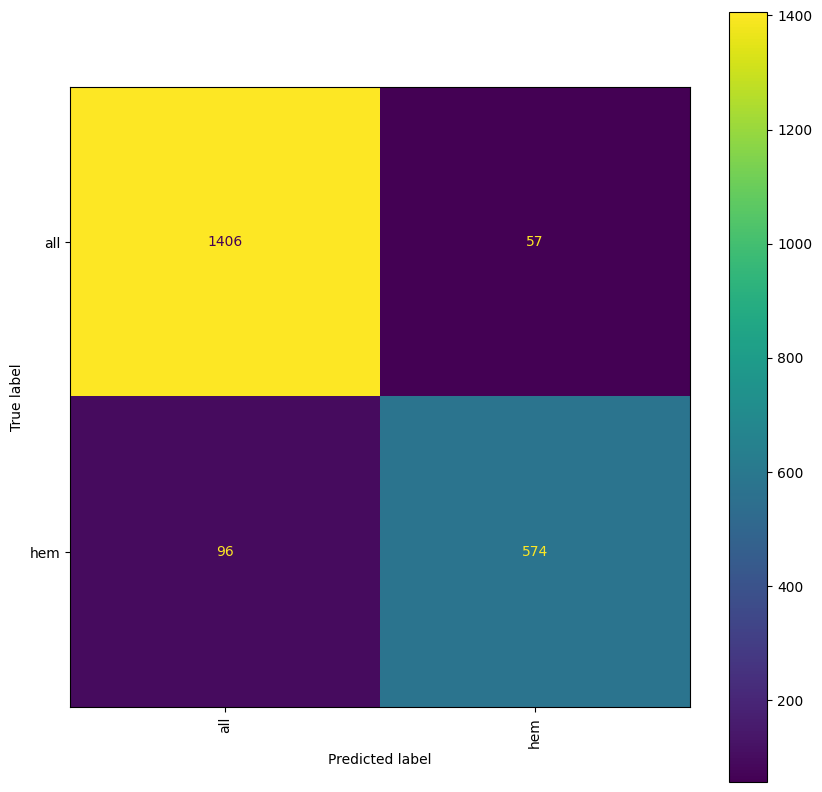

In [ ]:
model_test_scores = np.array(model_test_scores)
ensemble_scores = np.mean(model_test_scores, axis=0)
ensemble_prediction = np.rint(ensemble_scores)
evaluate_model(test_labels, ensemble_prediction)

# Weighted Average Model
While all classifiers perform relatively similarly, to maximize the effectiveness of the ensemble technique, it's wiser to compute a weighted average of the predictions. In this way, the best classifiers are assigned higher weights, while the less effective classifiers receive lower weights. This approach ensures that the most reliable models contribute more to the final prediction.

We will employ two distinct techniques to determine the best weights for the ensemble model. In both experiments, we will construct two models: one that aims to maximize accuracy on the validation set and another that strives to maximize precision for hem images.

## Brute force
One approach to discovering a suitable set of weights is to systematically explore all weight combinations within a certain step size, ensuring that the sum of all weights remains equal to 1. This method involves trying all possible combinations and retaining only the models that yield the best results on the validation set. With four models and a reasonably sized step (e.g., 0.05), this approach is manageable within a moderate timeframe.

However, it's important to note that the algorithmic complexity of this solution is O(step^n), where n represents the number of models. Consequently, if the number of models increases significantly or if you require a higher level of precision by reducing the step size, this approach can become impractical due to its exponential time complexity.

The following function will enable us to compute the weighted average of the predictions from the classifiers.

In [ ]:
def calculate_ensemble_prediction(model_scores, weights):
  model_scores = np.array(model_scores)
  ensemble_scores = np.average(model_scores, axis=0, weights=weights)
  ensemble_prediction = np.rint(ensemble_scores)
  return ensemble_prediction

In [ ]:
def compare_model(modelA, modelB, param1, param2):
  """
  return the best model between modelA and modelB considering first param1 and the param2
  """
  if modelA[param1] > modelB[param1]:
    return modelA
  if modelA[param1] < modelB[param1]:
    return modelB
  #in case of tie we return the best model wrt param2
  return modelA if modelA[param2] > modelB[param2] else modelB

In [ ]:
step = 0.05

#record of the best model wrt accuracy on test set
best_accuracy_model = {'weights':[], 'accuracy':0, 'precision_on_nocancer':0 }

#records of the best model wrt precision on test set
best_precision_model = {'weights':[], 'accuracy':0, 'precision_on_nocancer':0 }

for a in np.arange(0,1.01,step):
  for b in np.arange(0,1.01,step):
    for c in np.arange(0,1.01,step):
      for d in np.arange(0,1.01,step):
        if (a + b + c + d == 1):
          predictions = calculate_ensemble_prediction(model_val_scores, [a, b, c, d])
          acc, prec = get_accuracy_and_nocancer_precision(val_labels, predictions)
          new_model = {'weights':[a,b,c,d], 'accuracy':acc, 'precision_on_nocancer':prec}
          best_accuracy_model = compare_model(best_accuracy_model, new_model, 'accuracy', 'precision_on_nocancer')
          best_precision_model = compare_model(best_precision_model, new_model, 'precision_on_nocancer', 'accuracy')

Below, you can find the weights for the two models that were determined.

In [ ]:
best_accuracy_model

{'weights': [0.55, 0.05, 0.4, 0.0],
 'accuracy': 0.9324577861163227,
 'precision_on_nocancer': 0.9394904458598726}

In [ ]:
best_precision_model

{'weights': [0.35000000000000003, 0.15000000000000002, 0.5, 0.0],
 'accuracy': 0.9254221388367729,
 'precision_on_nocancer': 0.9527824620573356}

Here are the results for the two models:

Model with best accuracy: 
Weights: [0.55, 0.05, 0.4, 0.0]
Accuracy on the set: 0.9343647444913268
              precision    recall  f1-score   support

         all     0.9425    0.9631    0.9527      1463
         hem     0.9154    0.8716    0.8930       670

    accuracy                         0.9344      2133
   macro avg     0.9289    0.9174    0.9228      2133
weighted avg     0.9340    0.9344    0.9339      2133



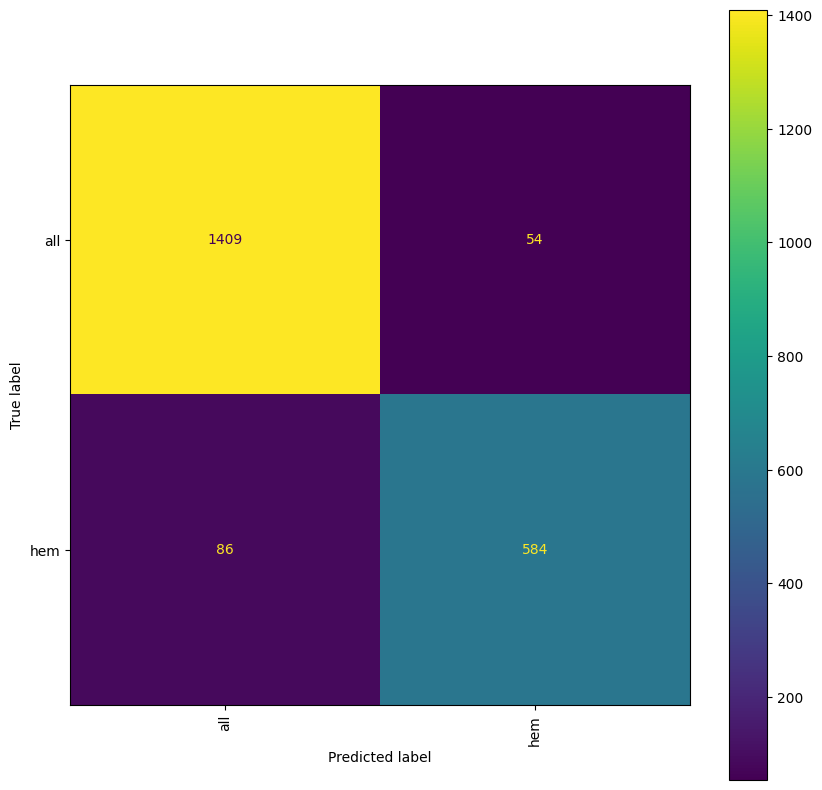

In [ ]:
print("Model with best accuracy: ")
print("Weights: " + str(best_accuracy_model['weights']))
best_acc_predictions = calculate_ensemble_prediction(model_test_scores, best_accuracy_model['weights'])
evaluate_model(test_labels, best_acc_predictions)

Model with best precision on nocancer images: 
Weights: [0.35000000000000003, 0.15000000000000002, 0.5, 0.0]
Accuracy on the set: 0.923581809657759
              precision    recall  f1-score   support

         all     0.9305    0.9604    0.9452      1463
         hem     0.9069    0.8433    0.8739       670

    accuracy                         0.9236      2133
   macro avg     0.9187    0.9018    0.9096      2133
weighted avg     0.9231    0.9236    0.9228      2133



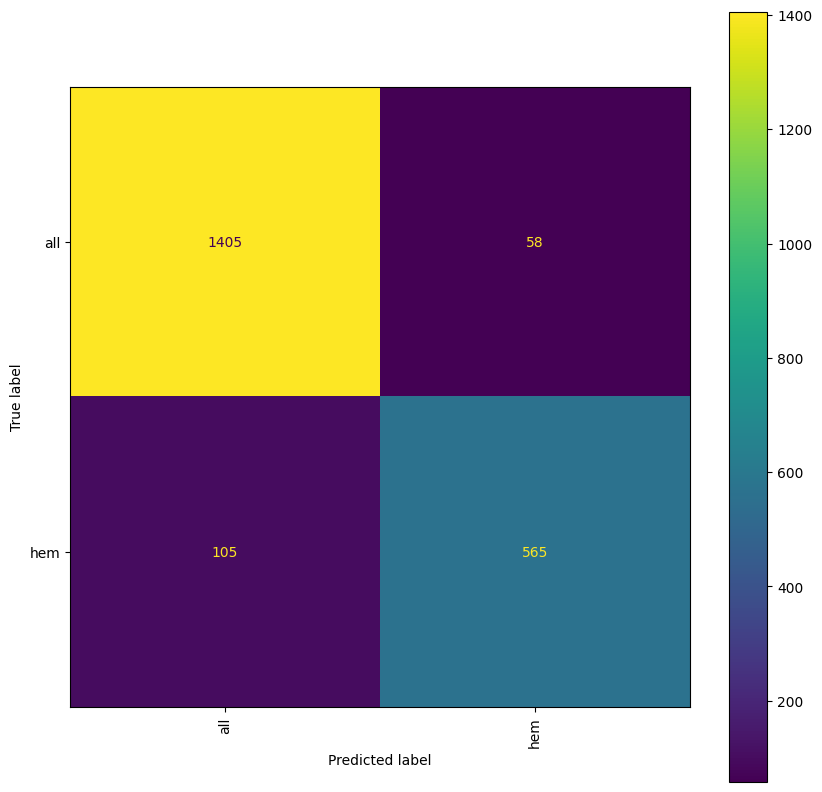

In [ ]:
print("Model with best precision on nocancer images: ")
print("Weights: " + str(best_precision_model['weights']))
best_prec_predictions = calculate_ensemble_prediction(model_test_scores, best_precision_model['weights'])
evaluate_model(test_labels, best_prec_predictions)

## Genetic Algorithm
The model weights can be determined using a Genetic Algorithm, where chromosomes consist of four genes, each representing the weight of a specific model. In each transformation step, such as crossover and mutation, the constraint that the sum of the genes in each chromosome remains equal to one will be maintained.

We will execute the algorithm twice, each time with a different fitness function: one based on accuracy on the validation set and the other focused on precision for "hem" images.

In [ ]:
def get_accuracy(weights): #First fit function
   predictions = calculate_ensemble_prediction(model_val_scores, weights)
   return metrics.accuracy_score(val_labels, predictions)

def get_precision_on_nocancer(weights): #Second fit function
   predictions = calculate_ensemble_prediction(model_val_scores, weights)
   return metrics.precision_score(val_labels, predictions, average='macro',labels=[1])

The functions for executing the genetic algorithm have been provided below. The code is inspired by [a post]('https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/') found on machinelearningmastery.com, and we have incorporated the necessary modifications, including normalizing each generated chromosome to ensure that the sum of the genes remains equal to one.

In [ ]:
# tournament selection
def tournament_selection(population, scores, k=5):
  selection_indexes = [rn.randrange(0, len(population), 1) for i in range(k)]
  selected_index = selection_indexes[0]
  for i in selection_indexes[1:]:

    if scores[i] > scores[selected_index]:
      selected_index = i
  return population[selected_index]

# average crossover
def crossover(parent_1, parent_2, r_genes):
  children_1, children_2 = parent_1.copy(), parent_2.copy()
  random_genes_indexes = [rn.randrange(0, len(parent_1), 1) for i in range(r_genes)]
  for i in random_genes_indexes:
    average = (parent_1[i] + parent_2[i])/2
    children_1[i] = average
    children_2[i] = average
  return [[float(i)/sum(children_1) for i in children_1],
          [float(i)/sum(children_2) for i in children_2]] # we normalize in order to keep the sum of the genes equal to 1

# all-positions mutation
def mutation(chromosome):
  index = rn.randint(0, len(chromosome)-1)
  chromosome[index] = rn.random()
  return [float(i)/sum(chromosome) for i in chromosome] # we normalize in order to keep the sum of the genes equal to 1



def genetic_algorithm(fitness, number_of_models, population_size, number_of_generations, p_crossover, p_mutation):
  # initial population of random chromosomes
  population = []
  for i in range(population_size):
    chromosome = [rn.random() for _ in range(number_of_models)]
    chromosome = [float(i)/sum(chromosome) for i in chromosome]
    population.insert(i, chromosome)
  # keep track of best solution
  best_chromosome, best_fitness = 0, fitness(population[0])
  # enumerate generations
  for generation in range(number_of_generations):
    # evaluate all candidates in the population
    scores = [fitness(chromosome) for chromosome in population]
    # check for new best solution
    new_best = False
    for i in range(population_size):
      if scores[i] > best_fitness:
        new_best = True
        best_chromosome, best_fitness = population[i], scores[i]
    if new_best:
      print("Generation %d, best fitness = %.4f" % (generation+1, best_fitness))
    # select parents
    selected = [tournament_selection(population, scores) for _ in range(population_size)]
    # create the next generation
    children = []
    for i in range(0, population_size, 2):
      # get selected parents in pairs
      p1, p2 = selected[i], selected[i+1]
      # crossover and mutation
      if rn.random() < p_crossover:
        for c in crossover(p1, p2, r_genes=2):
          if rn.random() < p_mutation:
            # mutation
            mutation(c)
          # store for next generation
          children.append(c)
      else:
        children.append(p1)
        children.append(p2)
    # replace population
    population = children
  return [best_chromosome, best_fitness]

We have identified the model with the highest accuracy:

In [ ]:
weights_best_acc = []
best_fitness = 0
for i in range(8):
  print("Iteration: " + str(i))
  weights, fitness = genetic_algorithm(get_accuracy, 4, 100, 50, 0.5, 0.01)
  if fitness > best_fitness:
    best_fitness = fitness
    weights_best_acc = weights
  print()

Iteration: 0
Generation 1, best fitness = 0.9320
Generation 3, best fitness = 0.9325
Generation 4, best fitness = 0.9329

Iteration: 1
Generation 1, best fitness = 0.9306
Generation 2, best fitness = 0.9325
Generation 3, best fitness = 0.9329

Iteration: 2
Generation 1, best fitness = 0.9311
Generation 2, best fitness = 0.9320
Generation 3, best fitness = 0.9325

Iteration: 3
Generation 1, best fitness = 0.9315
Generation 3, best fitness = 0.9325
Generation 4, best fitness = 0.9329
Generation 5, best fitness = 0.9334

Iteration: 4
Generation 1, best fitness = 0.9315
Generation 2, best fitness = 0.9325
Generation 5, best fitness = 0.9329
Generation 7, best fitness = 0.9334

Iteration: 5
Generation 1, best fitness = 0.9320
Generation 3, best fitness = 0.9325
Generation 4, best fitness = 0.9339

Iteration: 6
Generation 1, best fitness = 0.9315
Generation 2, best fitness = 0.9325
Generation 8, best fitness = 0.9329

Iteration: 7
Generation 1, best fitness = 0.9311
Generation 3, best fitnes

In [ ]:
print(weights_best_acc)

[0.43048445116406164, 0.15234862737048419, 0.3358364198457535, 0.08133050161970062]


Accuracy on the set: 0.9338959212376934
              precision    recall  f1-score   support

         all     0.9413    0.9638    0.9524      1463
         hem     0.9165    0.8687    0.8920       670

    accuracy                         0.9339      2133
   macro avg     0.9289    0.9162    0.9222      2133
weighted avg     0.9335    0.9339    0.9334      2133



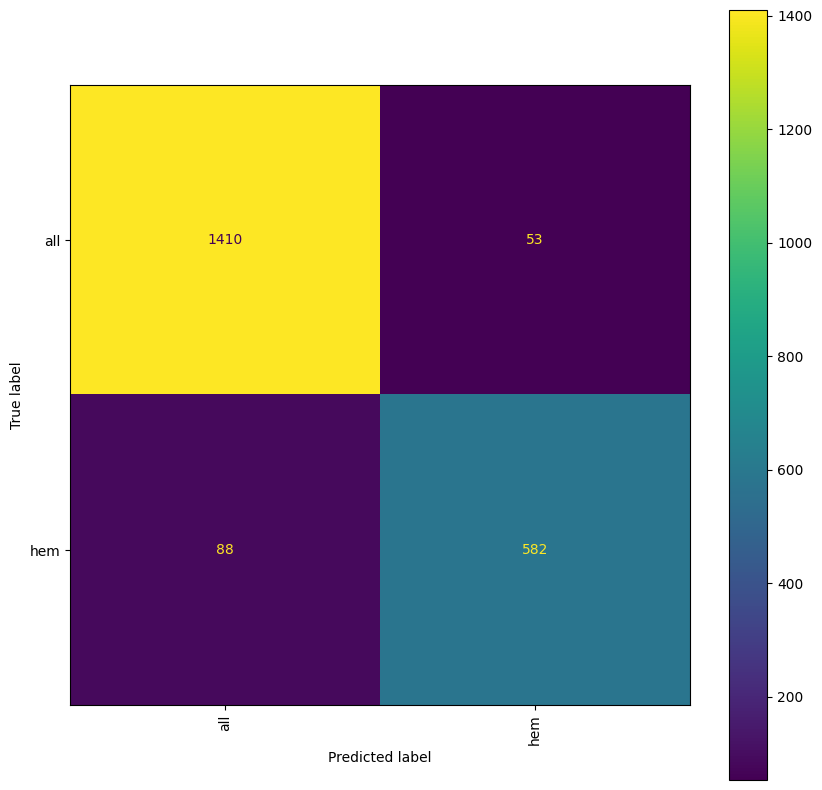

In [ ]:
best_acc_predictions = calculate_ensemble_prediction(model_test_scores, weights_best_acc)
evaluate_model(test_labels, best_acc_predictions)

We have identified the model with the highest precision:

In [ ]:
weights_best_prec = []
best_fitness = 0
for i in range(8):
  print("Iteration: " + str(i))
  weights, fitness = genetic_algorithm(get_precision_on_nocancer, 4, 100, 50, 0.5, 0.01)
  if fitness > best_fitness:
    best_fitness = fitness
    weights_best_prec = weights
  print()

Iteration: 0
Generation 1, best fitness = 0.9491
Generation 2, best fitness = 0.9511
Generation 7, best fitness = 0.9534
Generation 10, best fitness = 0.9550
Generation 11, best fitness = 0.9551

Iteration: 1
Generation 1, best fitness = 0.9501
Generation 2, best fitness = 0.9503
Generation 3, best fitness = 0.9538
Generation 27, best fitness = 0.9546
Generation 29, best fitness = 0.9548

Iteration: 2
Generation 1, best fitness = 0.9498
Generation 3, best fitness = 0.9517

Iteration: 3
Generation 1, best fitness = 0.9483
Generation 2, best fitness = 0.9517
Generation 3, best fitness = 0.9532

Iteration: 4
Generation 1, best fitness = 0.9491
Generation 3, best fitness = 0.9529
Generation 4, best fitness = 0.9547
Generation 5, best fitness = 0.9564

Iteration: 5
Generation 1, best fitness = 0.9503
Generation 3, best fitness = 0.9512
Generation 4, best fitness = 0.9536
Generation 5, best fitness = 0.9554

Iteration: 6
Generation 1, best fitness = 0.9471
Generation 3, best fitness = 0.9493

In [ ]:
print(weights_best_prec)

[0.3672381527513468, 0.3329207764272697, 0.291559678411386, 0.008281392409997415]


Accuracy on the set: 0.927332395686826
              precision    recall  f1-score   support

         all     0.9325    0.9638    0.9479      1463
         hem     0.9147    0.8478    0.8799       670

    accuracy                         0.9273      2133
   macro avg     0.9236    0.9058    0.9139      2133
weighted avg     0.9269    0.9273    0.9266      2133



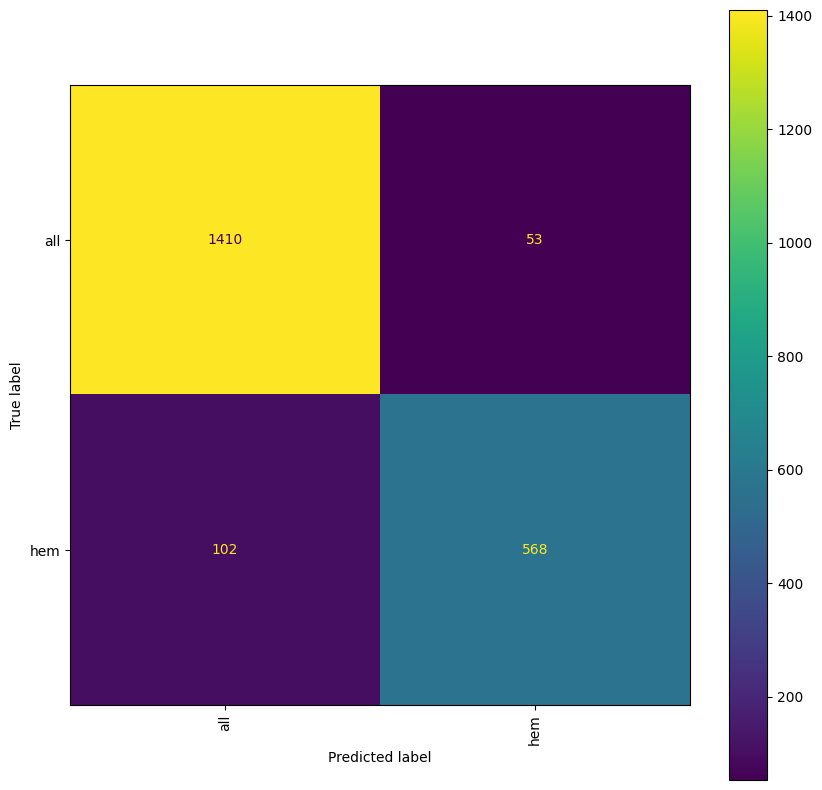

In [ ]:
best_prec_predictions = calculate_ensemble_prediction(model_test_scores, weights_best_prec)
evaluate_model(test_labels, best_prec_predictions)